# Modeling

*prose* does not implement a modeling framework, many options are currently available in python. However, it features some tools to aid in selecting the right model, mainly linear ones.

In this tutorial we will review some of these tools and show how the prose products can conveniently be used within `exoplanet`, itself using the `pymc3` inference framework.

## Making up some data

As usual we will work on synthetic data. Here we propose to analyse a planetary transit light curve in which we added some instrumental signals:

INFO Could not convert time to BJD TDB


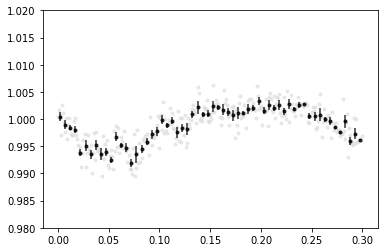

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from prose.simulations import observation_to_model

np.random.seed(37)

time = np.linspace(0, 0.3, 300)
obs = observation_to_model(time)
obs.plot()
_ = plt.ylim(0.98, 1.02)

<div class="alert alert-info">

Note

In what follows we will consider that we already have a good knowledge of our transit parameters. This is for the tutorial's purpose and one can adapt it by adjusting the model's priors (especially in the inference part).
</div>

## Linear models

### Polynomial systematics

It is common to model the instrumental signals using a linear model involving some systematic measurements. Let's say that we measured vector $\boldsymbol{x}$ along time. If $\boldsymbol{f}$ is our measured flux sampled along the same time, we can suppose that it can be modeled as a polynomial order 2 of $\boldsymbol{x}$ plus some **gaussian** noise, so that:

$$\boldsymbol{f} = a\boldsymbol{x}^2 + b\boldsymbol{x} +  c + \boldsymbol{\epsilon}$$

$a$, $b$, $c$ being free parameters. This can be writen in the matrix form:

$$\boldsymbol{f} =
\begin{pmatrix}a & b & c\end{pmatrix}
\begin{pmatrix} \boldsymbol{\phantom{,}x^2}\\\boldsymbol{x}\\\boldsymbol{1}\end{pmatrix} = 
wX$$

with $X$ the *design matrix*. $X$ is known so that this linear equation can be solved for $w$ through ordinary least square. Before doing any of that let's make sure our observation is clean

In [2]:
# removing obvious outlier
obs = obs.sigma_clip()

We can now use *prose* methods to build a linear model by defining its *design matrix*. Here we decided to set an order 2 polynomial of the sky data to start with

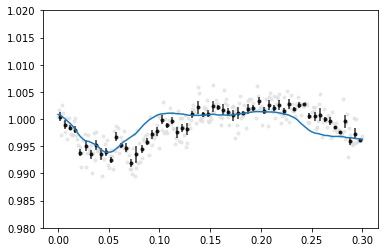

In [3]:
from prose import models
import matplotlib.pyplot as plt

dm = models.design_matrix([
    models.constant(obs.time),
    models.polynomial(obs.sky, 2)
])

trend = obs.trend(dm)

obs.plot()
plt.plot(obs.time, trend)
_ = plt.ylim(0.98, 1.02)

Although it's not very good, the model is certainly not complete. Let's make it better.

### Adding a transit

Our data contain a transit signal which, at first order, can be modeled as a scaled transit of unitary depth. To do that we will add this template to our design matrix. Here, we will use the more conveniant `Observation.polynomial()` method which comes handy for more complex models.

In [4]:
import numpy as np

t0 = 0.1
duration = 0.05

dm = np.hstack([
    obs.polynomial(sky=1, dy=1),
    obs.transit(t0, duration)
])

# Notice the use of split to get the transit model
trend, transit = obs.trend(dm, split=-1)

Let's do a nice plot

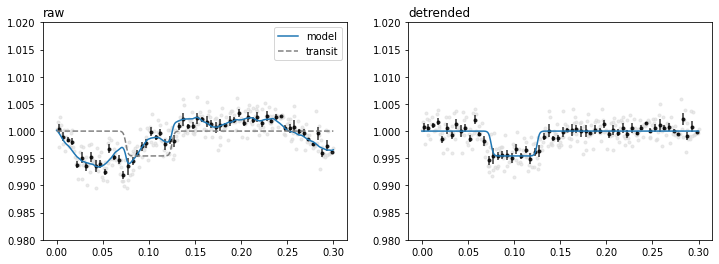

In [5]:
from prose import viz
plt.figure(figsize=(12,4))

plt.subplot(121)
obs.plot()
plt.plot(obs.time, transit + trend, label="model")
plt.plot(obs.time, transit + 1., "--", color="0.5", label="transit")
plt.ylim(0.98, 1.02)
plt.title("raw", loc="left")
plt.legend()

plt.subplot(122)
viz.plot_lc(obs.time, obs.flux - trend + 1.)
plt.plot(obs.time, transit + 1., label="transit")
plt.ylim(0.98, 1.02)
_ = plt.title("detrended", loc="left")

### Model selection

In the last sections we used arbitrary models of the systematics. It seems the last one is complete and not too complex but wiser choice can be made using model selection crtieria like [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)
or [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion). Here we will iterate on a range of possible models and compute which one gives the best BIC:

In [6]:
# we authorize combinations up to order 5

best = obs.best_polynomial(sky=5, dy=5, add=obs.transit(t0, duration))
print("best orders:", best)

best orders: {'sky': 1, 'dy': 2}


This confirms our previous guess and this order combination can be used within the next step to do a proper modeling. Before doing that let see what is the preferred model without a transit:

best orders: {'sky': 1, 'dy': 3}


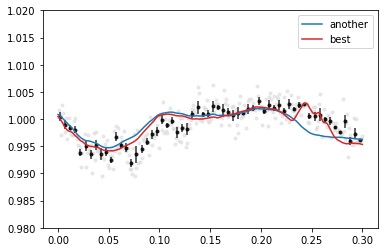

In [7]:
best = obs.best_polynomial(sky=5, dy=5)
print("best orders:", best)

another_trend = obs.polynomial(sky=1)
best_trend = obs.polynomial(**best)

obs.plot()
plt.plot(obs.time, obs.trend(another_trend), label="another")
plt.plot(obs.time, obs.trend(best_trend), c="C3", label="best")
plt.ylim(0.98, 1.02); _ = plt.legend()

This was just for fun and shows that adding `dy` order 3 favors the fit while keeping the model simple. We notice that this estimate naturraly depends on how complete the model is (here not complete due to the transit missing).

## Bayesian modeling

We will now use [exoplanet](https://docs.exoplanet.codes/en/stable/)  to infer of our transit parameters. For this part of the tutorial you will need [exoplanet](https://docs.exoplanet.codes/en/stable/) and [corner](https://corner.readthedocs.io/en/latest/) to be installed. Right now, we can instantiate the previously defined linear model for our systematics. This is done through `models.LinearModel` which nicely interfaces with `pymc3`:

In [8]:
# we use the best order combination found in the previous section

systematics = models.LinearModel(obs.polynomial(sky=1, dy=2).T)

The basic principle of `pymc3` is to let you define free parameters distributions and specify the models which depend on them before doing any computation. Doing so, a pre-optimized graph is built **once** making any later execution much faster. This comes handy for inference since a lot of  samples need to be drawn from your posterior distribution. Let's build our `pymc3` model with `exoplanet` (lot more details [here](https://docs.exoplanet.codes/en/stable/tutorials/transit/)):

In [9]:
import theano
import pymc3 as pm
import exoplanet as xo
from prose.utils import earth2sun

theano.config.compute_test_value = "warn"


with pm.Model() as model:
    
    # Transit parameters
    # -----------------
    period = pm.Uniform("period", 0.1, 3)
    r = pm.Uniform("r", 3, 8)*earth2sun
    
    # Keplerian orbit
    # ---------------
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=0.1)
    # starry light-curve
    light_curves = xo.LimbDarkLightCurve([0.1, 0.4]).get_light_curve(orbit=orbit, r=r, t=obs.time)
    transit = pm.Deterministic("transit", pm.math.sum(light_curves, axis=-1))
    
    # Systematics and final model
    # ---------------------------
    residuals = pm.Deterministic("residuals", obs.flux - transit)
    mu = pm.Deterministic("mu", transit + systematics(residuals))

    # Likelihood function
    # -----------------------------
    pm.Normal("obs", mu=mu, sd=obs.error, observed=obs.flux)

    # Maximum a posteriori
    # --------------------
    opt = xo.optimize(start=model.test_point, progress_bar=False)

optimizing logp for variables: [r, period]
message: Desired error not necessarily achieved due to precision loss.
logp: 1419.8315178507357 -> 1448.2841596037292


We can plot the maximum a posteriori which will be the starting point of our sampling algorithm

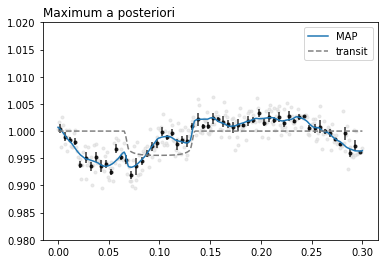

In [10]:
obs.plot()
plt.plot(obs.time, opt["mu"], label="MAP")
plt.plot(obs.time, opt["transit"]+1, "--", color="0.5", label="transit")
plt.ylim(0.98, 1.02)
plt.title("Maximum a posteriori", loc="left")
_ = plt.legend()

Not bad already. Let's sample the posterior likelihood

In [11]:
np.random.seed(42)

with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=opt,
        cores=2,
        chains=2,
        init="adapt_full",
        target_accept=0.9,
        return_inferencedata=False 
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/lionelgarcia/Code/envs/prose/lib/python3.6/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, period]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


We can now make a corner plot of the parameters of interest. We marked in blue the true values used to generate our synthetic data.

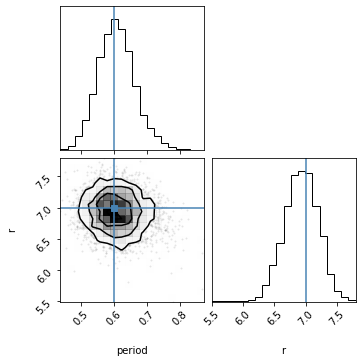

In [12]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
_ = corner.corner(samples, truths=[0.6, 7.])

Quite close! Again, our priors are not realistic and inferring the parameters of a real unknown transit will require some adjustments.

## Recomendations

We highly recomand the use of the excellent `exoplanet` (and `starry` for more speific needs) packages and documentations. To see if they fit your needs, the [case studies pages](https://gallery.exoplanet.codes/en/latest/) of `exoplanet` is a good place to start.